# AGB Yields
This notebook explores different representations and uncertanties with the 
AGB yield tables we have as applied to GCE Models.
In particular, we consider the yield tables as 2D functions of mass and metallicity,
1D functions of metallicity, and 1D functions of time.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy

import vice

import arya
import surp
from surp._globals import AGB_MODELS
from surp import yields
from surp.gce_math import Z_SUN, MH_to_Z, Z_to_MH, calc_y

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
from singlezone import run_singlezone

In [4]:
surp.set_yields()

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.28e-03 + 8.14e-01 (Z - Z0)   1.00 × cristallo11             0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





In [5]:
y_agb = vice.yields.agb.settings

In [6]:
agb_grid = vice.yields.agb.grid

In [7]:
agb_interpolator = surp.agb_interpolator.interpolator

In [46]:
AGB_LABELS = ["FRUITY", "ATON", "MONASH",  "NuGrid"]

In [47]:
AGB_MODELS, AGB_LABELS

(['cristallo11', 'ventura13', 'karakas16', 'pignatari16'],
 ['FRUITY', 'ATON', 'MONASH', 'NuGrid'])

In [48]:
Z_max = 0.02
Z_min = 0.0001

hmap = arya.figure.colorbar.HueMap((Z_to_MH(Z_min),Z_to_MH(Z_max)))


def plot_yield_table(study = "cristallo11", hmap=hmap, ele="c", fmt="o", 
                     ax=None, fig=None, factor=1, **kwargs):
    """
    Plots the yield table in VICE (without modification) for each metallicity
    """
    
    if ax is None:
        ax = plt.gca()
        ylabel = r"$Y_{\rm C}^{\rm AGB}$"
        if factor != 1:
            ylabel += "$\quad [\times 10^{-%i}]$" % np.log10(factor)
        ax.set(xlabel=r'Mass / ${\rm M}_\odot$', ylabel=ylabel )
        
    yields, masses, Zs = agb_grid(ele, study=study)
    N = len(Zs)

    for i in range(N):
        y = np.array(yields)[:,i] * factor
        Z = Zs[i]
        c = hmap(Z_to_MH(Z))
        f = ax.plot(masses, y, fmt, label=f"Z = {Z}", c=c, **kwargs)
    
    ax.axhline(0, color="k", ls=":", zorder=-1)

    return f

In [49]:
def plot_yields(study = "cristallo11", masses=np.linspace(0.08, 8.01, 1000), Zs=None, ele="c", 
                ax=None, fig=None, hmap=hmap, factor=1, **kwargs):
    """
    Plots the yields (assuming the current setting is a surp.agb_interpolator)
    for each given mass and metallicity.
    
    """
    
    if ax is None:
        ax = plt.gca()
        ylabel = r"$Y_{\rm C}^{\rm AGB}$"
        if factor != 1:
            ylabel += "$\quad [\times 10^{-%i}]$" % np.log10(factor)
        ax.set(xlabel=r'Mass / ${\rm M}_\odot$', ylabel=ylabel )


    if Zs is None:
        _yields, _masses, Zs = agb_grid(ele, study=y_agb[ele].study)
    
    ya = y_agb[ele]
    for i in range(len(Zs)):
        Z = Zs[i] 
        c = hmap(Z_to_MH(Z))
        y = [ya(m, Z)*factor for m in masses]
        f = ax.plot(masses, y, label=f"Z = {Z}", c=c, **kwargs)

    return f

In [50]:
def plot_y_z(Zs=MH_to_Z(np.linspace(-2.7, 0.6, 100)), ele="c", kind="agb", fmt="-", factor = 1e4, **kwargs):
    """
        plot_y_z(Zs, ele, kind, fmt, factor, kwargs)
    
    plots the metallicity dependence of the AGB yield over a given range of metallicities. 
    Uses the current yield setting
    """
    
    y_c_agb = calc_y(Zs, ele=ele, kind=kind) * factor
    
    plt.axhline(0, color="k", ls=":")
    plt.xlabel(r"$\log Z/Z_\odot$")
    plt.ylabel(r"$y_{\rm C}^{\rm AGB}\quad[\times 10^{-%i}]$" % np.log10(factor))
    
    return plt.plot(Z_to_MH(Zs), y_c_agb, fmt, **kwargs), y_c_agb

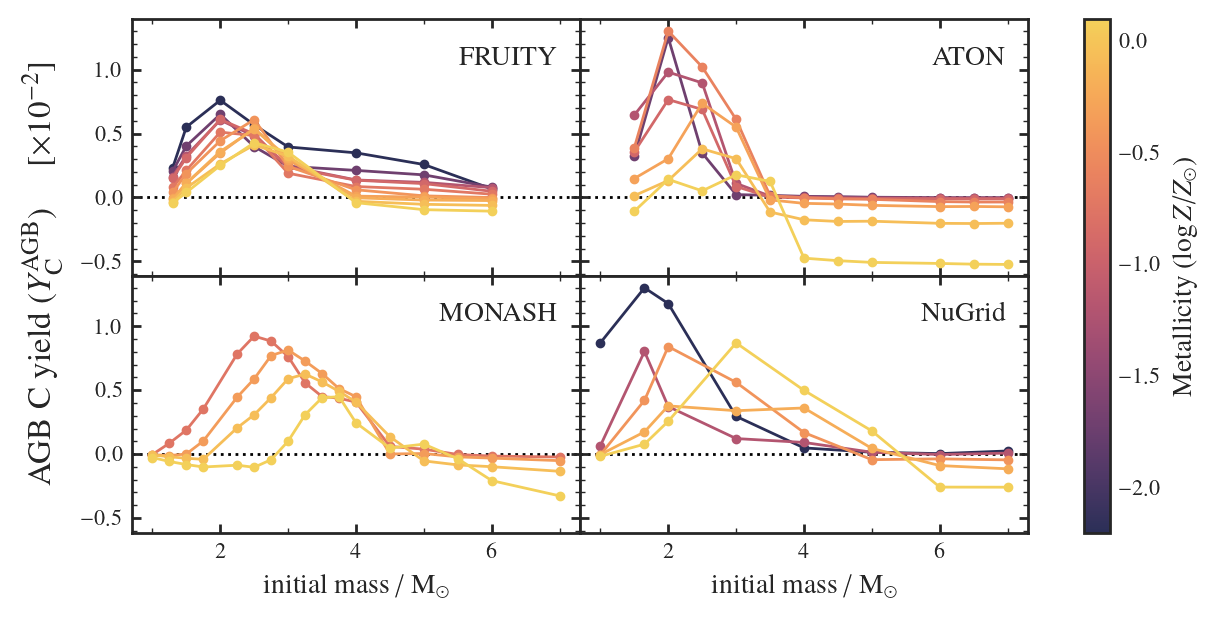

In [51]:
SCALE_FACTOR=1e2
fig, axs = plt.subplots(2, 2, figsize=(7, 10/3), sharex=True, sharey=True, gridspec_kw={"hspace":0, "wspace": 0, "left": 0.1})

for i in range(4):
    study = AGB_MODELS[i]
    label = AGB_LABELS[i]
    ax = axs[i//2][i%2]
    f = plot_yield_table(study, ax=ax, fig=fig, fmt="o-", factor=SCALE_FACTOR)
    
    # plot label
    ax.text(0.95, 0.9, label, horizontalalignment='right',
            verticalalignment='top', transform=ax.transAxes)
    


arya.Colorbar(huemap=hmap, ax=axs.ravel().tolist(), label=r"Metallicity ($\log Z/Z_\odot$)")

plt.setp(axs[-1, :], xlabel=r'initial mass / ${\rm M}_\odot$')
fig.supylabel(r"AGB C yield ($Y_{\rm C}^{\rm AGB}$) $\quad [\times 10^{-2}]$")

plt.gca().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

plt.savefig("figures/agb_yields.pdf")

The AGB figure of the paper

In [ ]:
x_min = -2.8
x_max = 0.6
N_points = 100
scale = 1e4
ele = "c"

vice.yields.ccsne.settings[ele] = 0
vice.yields.sneia.settings[ele] = 0

plt.figure(figsize=(10/3, 10/3))

for i in range(4):
    model = AGB_MODELS[i]

    vice.yields.agb.settings[ele] = agb_interpolator(ele, study=model)
    kwargs = dict(fmt="o", zorder=i, factor=scale, color=arya.COLORS[i])
    
    # plots importaint points
    _y1, _m1, Zs = vice.yields.agb.grid('c', study=model)
    (line,), _x = plot_y_z(Zs, **kwargs)
    
    # plot solid within range
    MoverH_min = Z_to_MH(min(Zs))
    MoverH_max = Z_to_MH(max(Zs))
    
    kwargs["fmt"] = "-"
    kwargs["lw"] = 0.5
    Zs = MH_to_Z(np.linspace(MoverH_min, MoverH_max, N_points))
    plot_y_z(Zs, label=AGB_LABELS[i], **kwargs)

    # dashed extrapolation
    kwargs["fmt"] = "--"
    Zs = MH_to_Z(np.linspace(x_min, MoverH_min, N_points))    
    plot_y_z(Zs, **kwargs)
    Zs = MH_to_Z(np.linspace(MoverH_max, x_max, N_points))
    plot_y_z(Zs, **kwargs)





arya.Legend(color_only=True, handlelength=0, ncols=2, columnspacing=1, loc=3, transpose=True)

plt.savefig("figures/y_agb_vs_z.pdf")

In [15]:
tau_switch = 1
def plot_ssp_time(ele="c", Z=surp.Z_SUN, imf="kroupa", normalize=True, dt=0.01, t_end=10, color=None, verbose=True, **kwargs):
    """
        plot_ssp_time(ele, Z, normalize, **kwargs(
        
    plots the SSP yield over time for the current yield setting
    """
    
    m_c, times = vice.single_stellar_population(ele, Z=Z, dt=dt, time=t_end, mstar=1, IMF=imf)
    
    y = np.array(m_c)
    if normalize:
        y /= y[-1]
    
    plt.plot(times, y, color=color, **kwargs)
    
    
    # plot 50% time
    f = scipy.interpolate.interp1d(y, times)

    y_1_2 = 0.5*y[-1]
    plt.scatter(f(y_1_2), y_1_2, color=color)
        
    if verbose:
        print(f"model = {y_agb[ele]}")
        print(f"t1/2 = {f(y_1_2):0.2f}")

        times = np.array(times)
        idx = np.where(times >= tau_switch)[0][1]

        y_late = y[-1] - y[idx]
        print(f"y(t>{times[idx]}) = {y_late:0.2f}")
        print(f"y max = {np.max(y):0.2f}")
        print(f"y min = {np.min(y):0.2f}")
   
        print()
    
    plt.xlabel(r"$t$ / Gyr")
    plt.xscale("log")
    
    if normalize:
        plt.ylabel(r"$y_{\rm C}^{\rm AGB}(t)\;/\;y_{\rm C}^{\rm AGB}(t_{\rm end})$")
    else:
        plt.ylabel(r"$y_{\rm C}^{\rm AGB}(t)$")

    
    return times, y

model = 1.00 × cristallo11
t1/2 = 0.79
y(t>1.01) = 0.34
y max = 1.03
y min = -0.19

model = 1.00 × ventura13
t1/2 = 1.74
y(t>1.01) = 1.97
y max = 1.00
y min = -7.81

model = 1.00 × karakas16
t1/2 = 0.37
y(t>1.01) = -0.06
y max = 1.10
y min = -0.21

model = 1.00 × pignatari16
t1/2 = 0.52
y(t>1.01) = 0.23
y max = 1.00
y min = -0.12

model = 0
t1/2 = 0.96
y(t>1.01) = 0.49
y max = 1.00
y min = 0.00



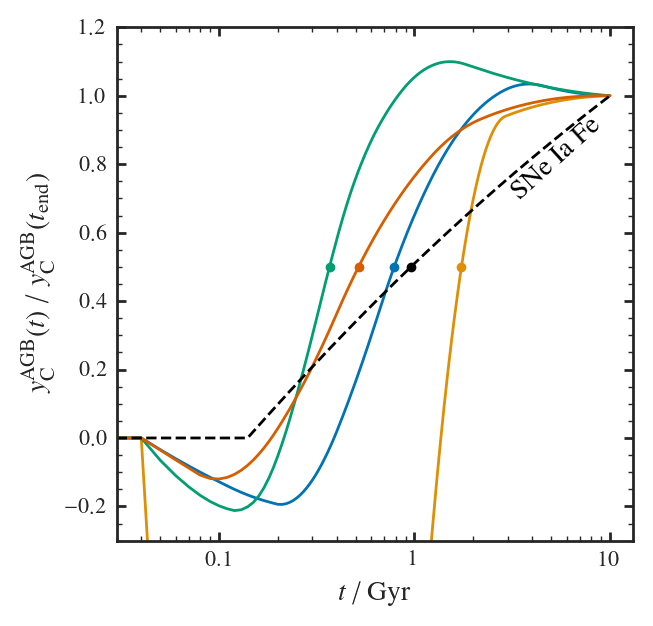

In [16]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0
vice.yields.agb.settings["fe"] = surp.yield_models.ZeroAGB()


for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings["c"] = agb_interpolator("c", study=model)
    times, y = plot_ssp_time()
  
    
plt.text(3, 0.7, "SNe Ia Fe", rotation=42, color="k")
plot_ssp_time("fe", color="k", ls="--")


plt.ylim(-0.3, 1.2)
plt.xlim(0.03, 13.2)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])

plt.savefig("figures/y_agb_vs_t.pdf")

# Extra

# Lin Approx

In [29]:
import sys
sys.path.append("../models/")
import make_yields

In [30]:
make_yields.Y_C_AGB

{'cristallo11': 0.00038,
 'ventura13': 0.000185,
 'karakas16': 0.00028,
 'pignatari16': 0.00059}

0.00038
-0.00035
0.000185
-0.00094
0.00028
-0.00101
0.00059
-0.00057


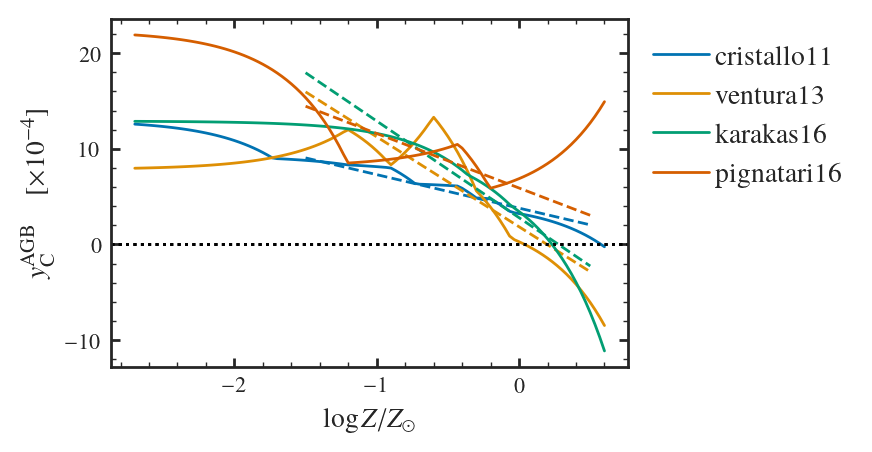

In [40]:
for model in AGB_MODELS:
    vice.yields.agb.settings["c"] = agb_interpolator("c", study=model)
    line = plot_y_z(label=model)
    y0 = make_yields.Y_C_AGB[model]
    zeta =  make_yields.ZETA_C_AGB[model]
    MH = np.linspace(-1.5, 0.5, 1000)
    print(y0)
    print(zeta)
    plt.plot(MH, 1e4 * (y0 + zeta*MH), ls="--", color=line[0][0].get_color())
    

arya.Legend(-1)

## DTS

model = cristallo11
t1/2 = 0.81
y(t>1.01) = 0.36
y max = 1.00
y min = -0.19

model = ventura13
t1/2 = 1.71
y(t>1.01) = 2.03
y max = 1.00
y min = -8.29

model = karakas16
t1/2 = 0.38
y(t>1.01) = -0.00
y max = 1.04
y min = -0.20

model = pignatari16
t1/2 = 0.52
y(t>1.01) = 0.23
y max = 1.00
y min = -0.12

model = 0
t1/2 = 0.96
y(t>1.01) = 0.49
y max = 1.00
y min = 0.00



([<matplotlib.axis.XTick at 0x2b2453b84b50>,
 [Text(0.1, 0, '0.1'), Text(1.0, 0, '1'), Text(10.0, 0, '10')])

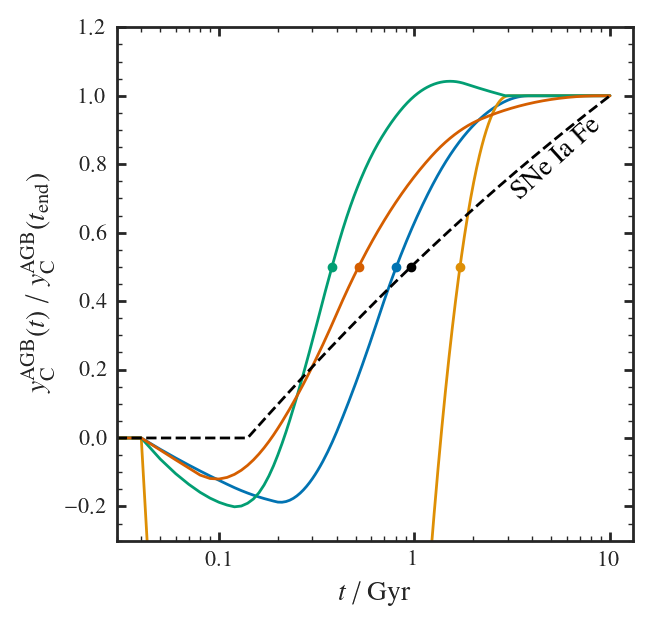

In [17]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0

for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings["c"] = model
    plot_ssp_time(label=model)
    

plt.text(3, 0.7, "SNe Ia Fe", rotation=42, color="k")
plot_ssp_time("fe", color="k", ls="--")

plt.ylim(-0.3, 1.2)
plt.xlim(0.03, 13.2)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])


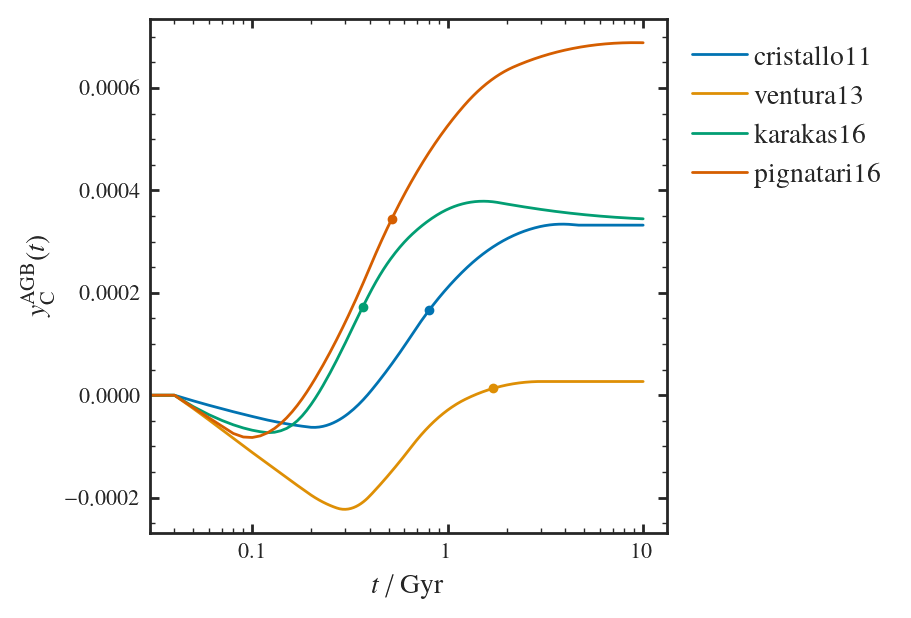

In [18]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0
vice.yields.agb.settings["fe"] = surp.yield_models.ZeroAGB()
Z = MH_to_Z(-0.0)


for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings["c"] = agb_interpolator("c", study=model)
    plot_ssp_time(normalize=False, Z=Z, label=model, verbose=False)



plt.xlim(0.03, 13.2)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])
arya.Legend(-1)


same as figure just above but for VICE default settings

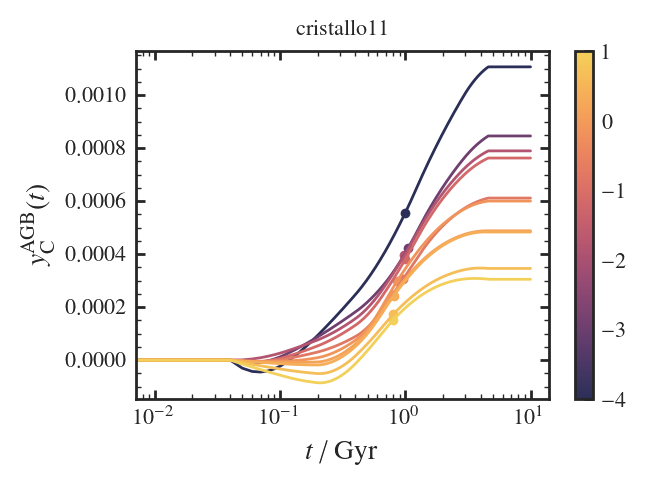

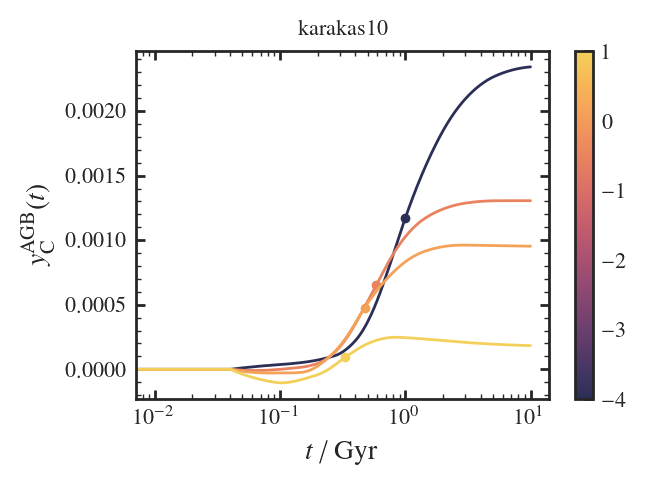

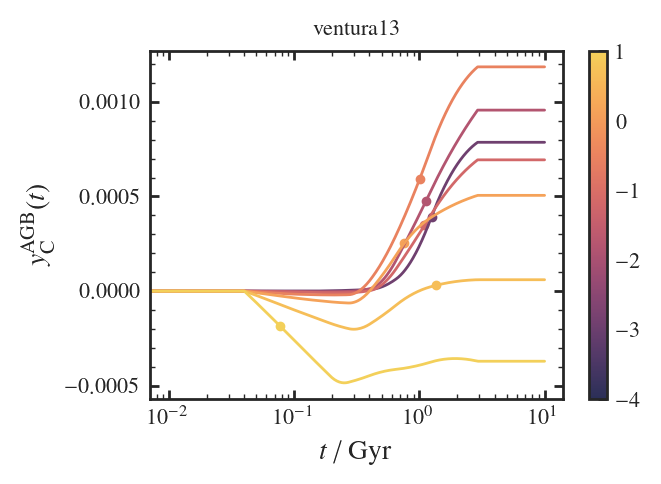

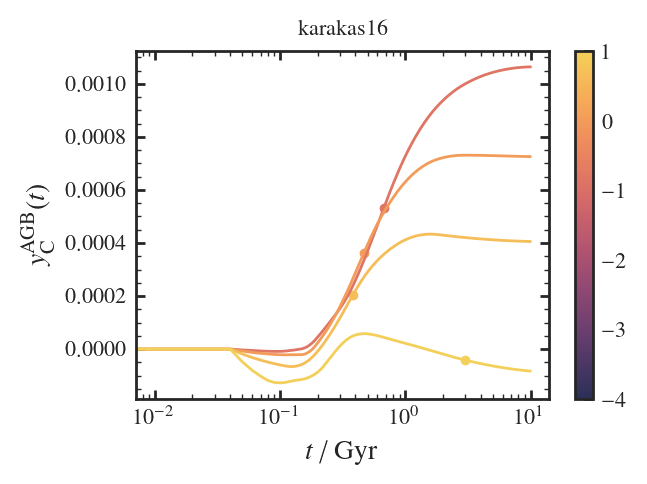

In [19]:
cmap = arya.style.get_cmap()



model = "cristallo11"
mpp = arya.figure.colorbar.HueMap([-4, 1])


for model in ["cristallo11", "karakas10", "ventura13", "karakas16"]:
    _, _, z1 = vice.yields.agb.grid("c", model)
    plt.title(model)

    plt.xscale("log")
    cmap = arya.style.get_cmap()
    y_agb["c"] = agb_interpolator("c", study=model)
    for i in range(len(z1)):
        z = z1[i]
        plot_ssp_time(Z=z, color=hmap(Z_to_MH(z)), normalize=False, verbose=False)



    arya.Colorbar(huemap=mpp, ax=plt.gca())
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


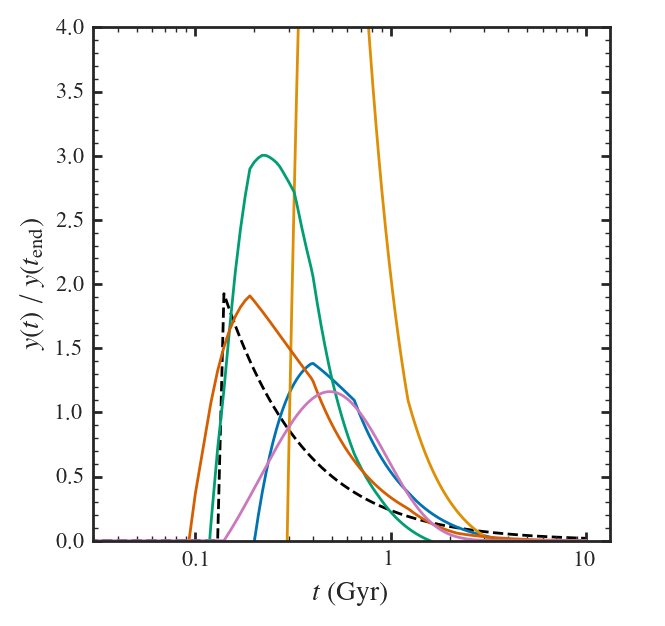

In [20]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0

for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings["c"] = model
    m_c, times = vice.single_stellar_population("c", Z=0.014 * 10**0, dt=0.01)
    y = np.array(m_c)/m_c[-1]
    dt = times[1] - times[0]
    plt.plot(times[:-1], (y[1:] - y[:-1])/dt)
        

m_fe, times = vice.single_stellar_population("fe", Z=0.014)
y = np.array(m_fe)/m_fe[-1]
plt.plot(times[:-1], (y[1:] - y[:-1])/dt, 
         linestyle="--", zorder=-1, color="k")



plt.xlabel(r"$t$ (Gyr)")
plt.ylabel(r"$y(t)\;/\;y(t_{\rm end})$")
plt.xscale("log")
plt.xlim(0.03, 13.2)
plt.ylim(0, 4)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])
x = np.array(times)


vice.yields.agb.settings["c"] = surp.yield_models.C_AGB_Model()
m_c, times = vice.single_stellar_population("c", Z=0.014 * 10**0, dt=0.01)
y = np.array(m_c)/m_c[-1]
dt = times[1] - times[0]
plt.plot(times[:-1], (y[1:] - y[:-1])/dt)

arya.Legend(-1)

## yields 

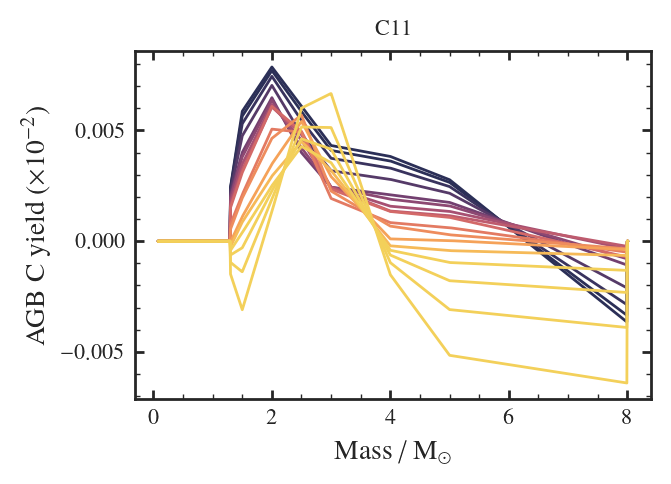

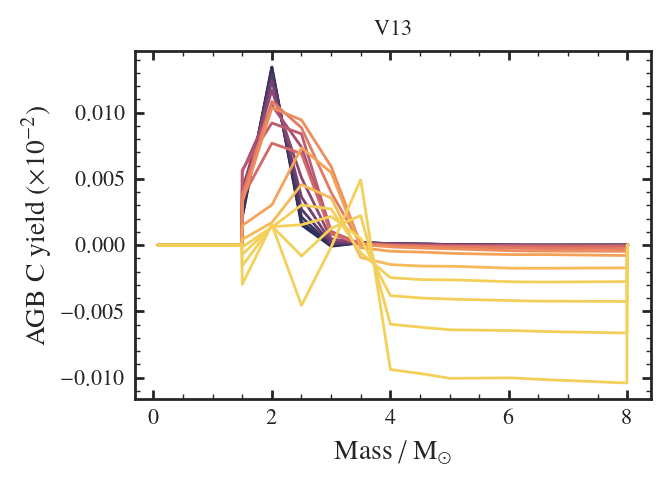

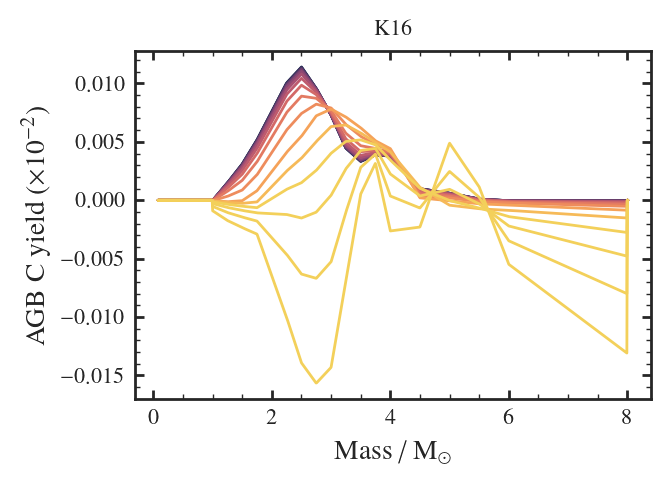

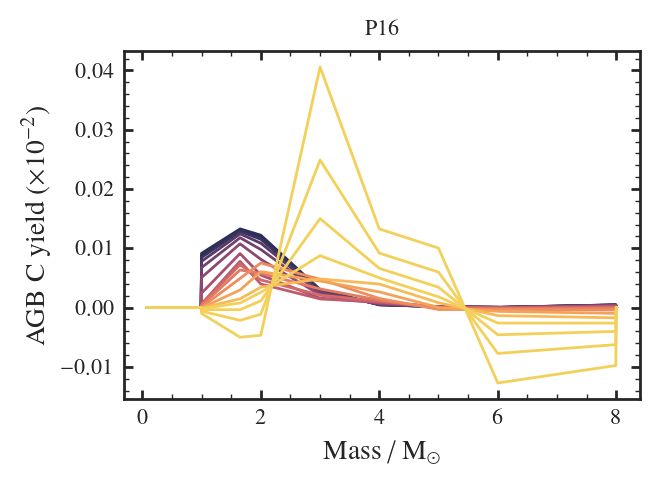

In [21]:
Zs = MH_to_Z(np.arange(-2.5, 0.8, 0.2))
for i in range(4):
    study = AGB_MODELS[i]
    label = AGB_LABELS[i]
    y_agb["c"] = agb_interpolator("c", study=study)
    plot_yields(study, Zs=Zs)
    plt.xlabel(r'Mass / ${\rm M}_\odot$')
    plt.ylabel(r"AGB C yield ($\times 10^{-2}$)")
    plt.title(label)
    plt.show()

## Interpolation methods

In [49]:
y_c_lin = agb_interpolator("c", interp_kind="linear", low_z_flat=False)
y_c_log = agb_interpolator("c", interp_kind="log", low_z_flat=True)
y_c_spline = agb_interpolator("c", interp_kind="spline")

y_cs = {
    "linear": y_c_lin,
    "log": y_c_log,
    "spline": y_c_spline
}

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.30e-03 + 1.63e-03 [M/H] or   1.44 × cristallo11             0                              
                    8.67e-04, else                                                                               

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





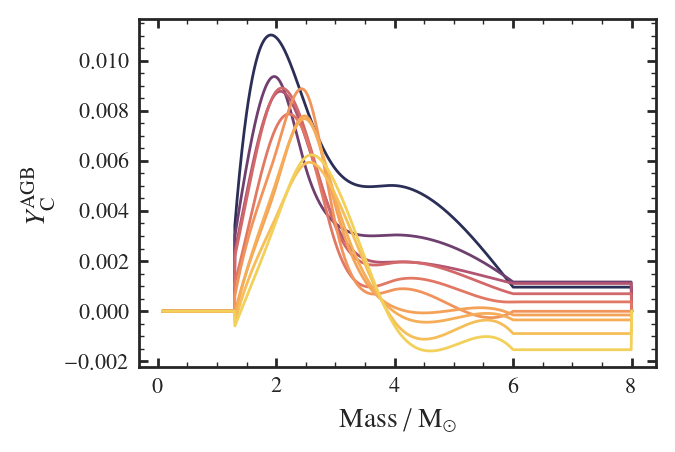

In [44]:
# just making sure this works
surp.set_yields(surp.YieldParams.from_file("../models/C11_f0.2_splineint/yield_params.json"))
plot_yields()

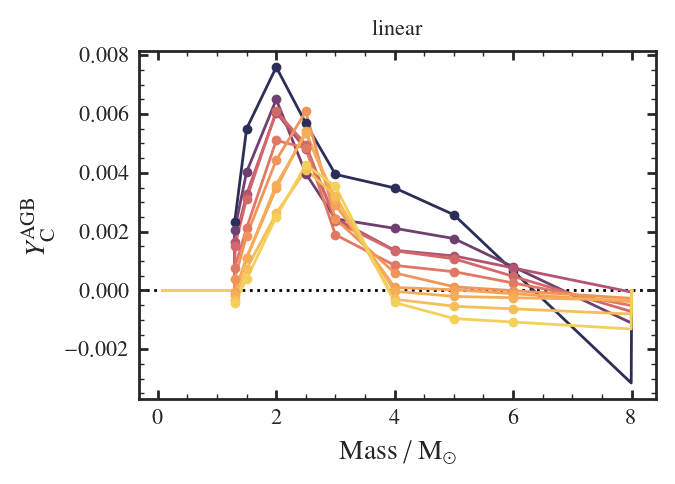

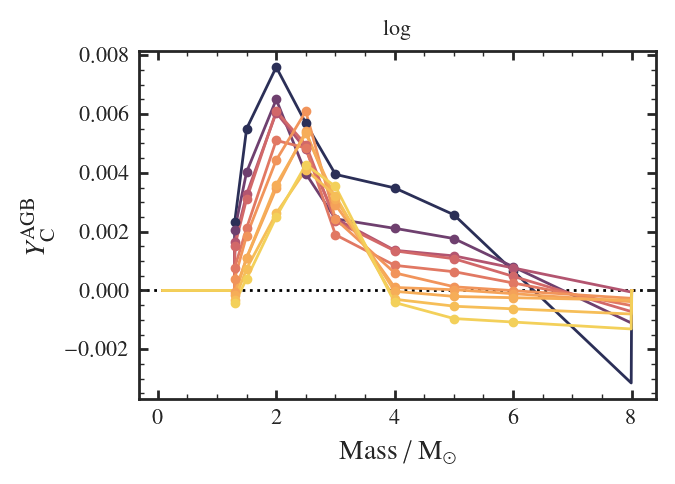

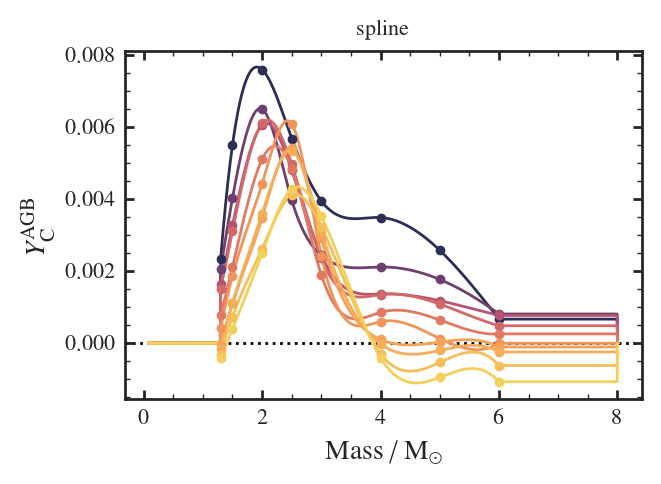

In [45]:
Z = MH_to_Z(np.linspace(-3, 1, 15))

for label, model in y_cs.items():
    vice.yields.agb.settings["c"] = model

    plot_yields()
    plot_yield_table()
    plt.title(label)
    plt.show()



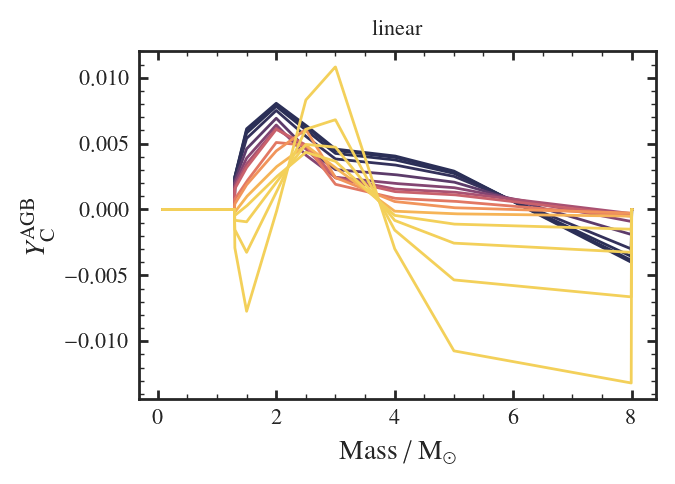

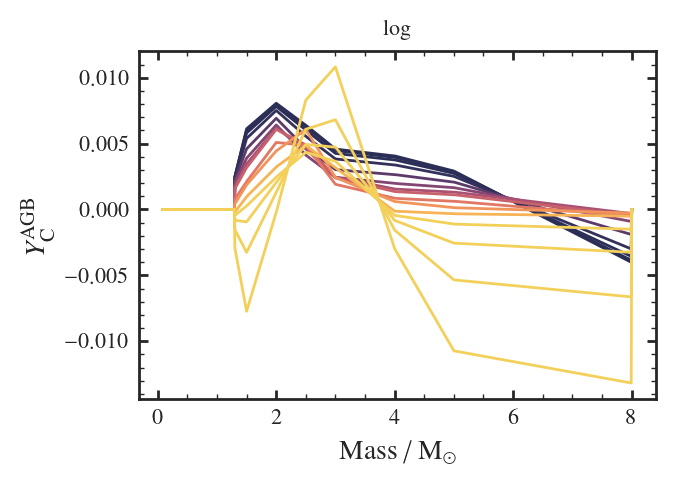

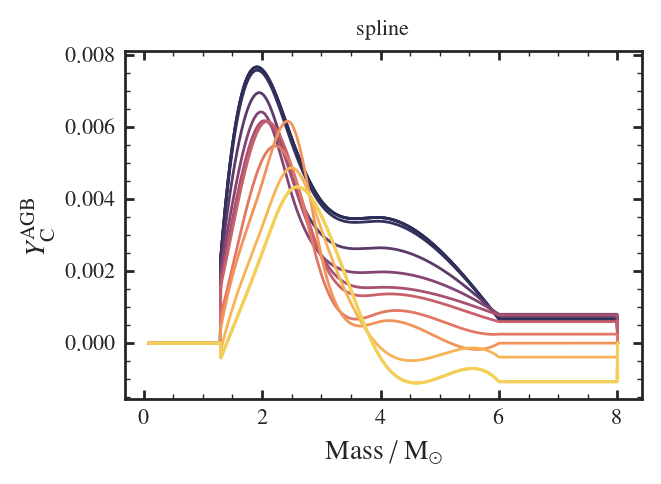

In [46]:
Zs = MH_to_Z(np.linspace(-3, 1, 15))

for label, model in y_cs.items():
    vice.yields.agb.settings["c"] = model

    plot_yields(Zs=Zs)
    plt.title(label)
    plt.show()



model = 1.00 × cristallo11
t1/2 = 0.80
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00

model = 1.00 × cristallo11
t1/2 = 0.80
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00

model = 1.00 × cristallo11
t1/2 = 0.81
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00



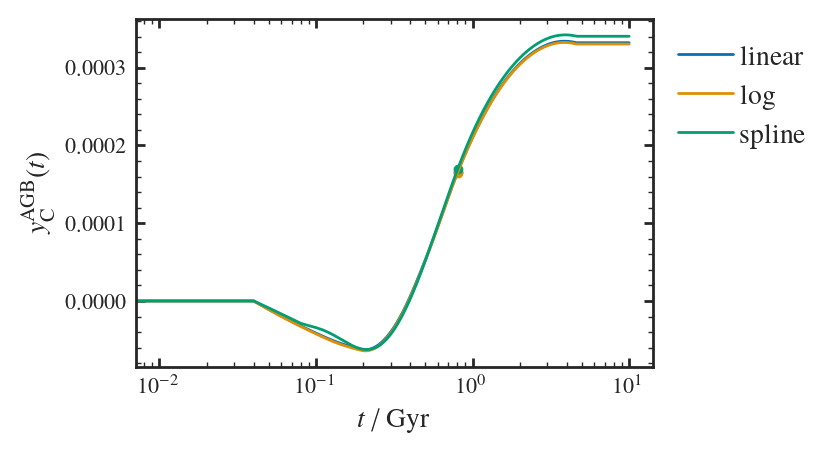

In [52]:
Z = 0.016
vice.yields.ccsne.settings["c"] = 0
for label, model in y_cs.items():
    vice.yields.agb.settings["c"] = model

    plot_ssp_time(normalize=False, Z=Z, label=label)

arya.Legend(-1)


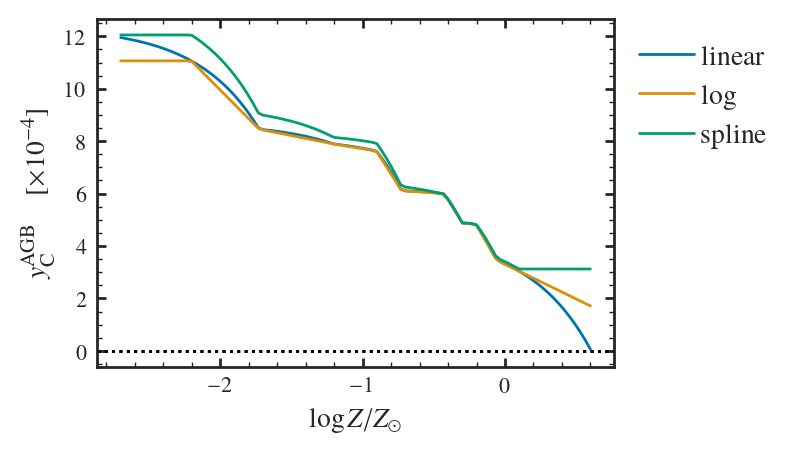

In [51]:

for label, model in y_cs.items():
    vice.yields.agb.settings["c"] = model
    plot_y_z(label=label)

arya.Legend(-1)


Like DTD figures but for the derivative.

In [27]:
params_lin = surp.YieldParams.from_file("../models/C11_f0.2_lininterp/yield_params.json")
params_fiducial = surp.YieldParams.from_file("../models/C11_f0.2/yield_params.json")

params_lin.c_agb_alpha = 1
params_fiducial.c_agb_alpha = 1

/tmp/slurmtmp.28458698/ipykernel_174904/1831873281.py:15: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  return plt.plot(Z_to_MH(Zs), y_c_agb, fmt, **kwargs), y_c_agb


Text(0, 0.5, 'yield')

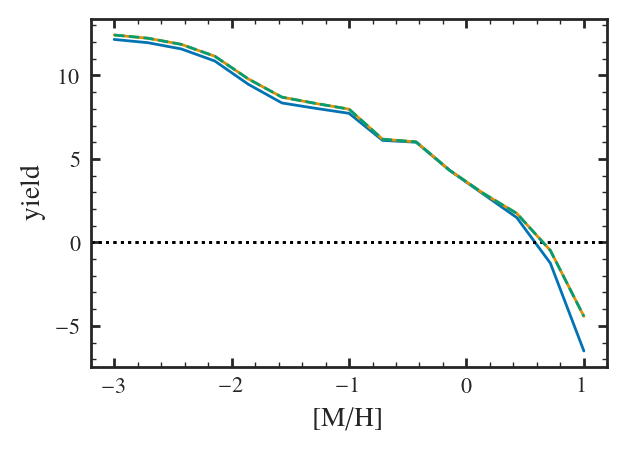

In [28]:

surp.yields.set_yields(params_fiducial, verbose=False)
plot_y_z(Zs);

surp.yields.set_yields(params_lin, verbose=False)
plot_y_z(Zs);


vice.yields.agb.settings["c"] = "cristallo11"
plot_y_z(Zs, ls="--");

plt.xlabel("[M/H]")
plt.ylabel("yield")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


model = 1.00 × cristallo11
t1/2 = 0.81
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00


model = 1.00 × cristallo11
t1/2 = 0.88
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00


model = cristallo11
t1/2 = 0.88
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00



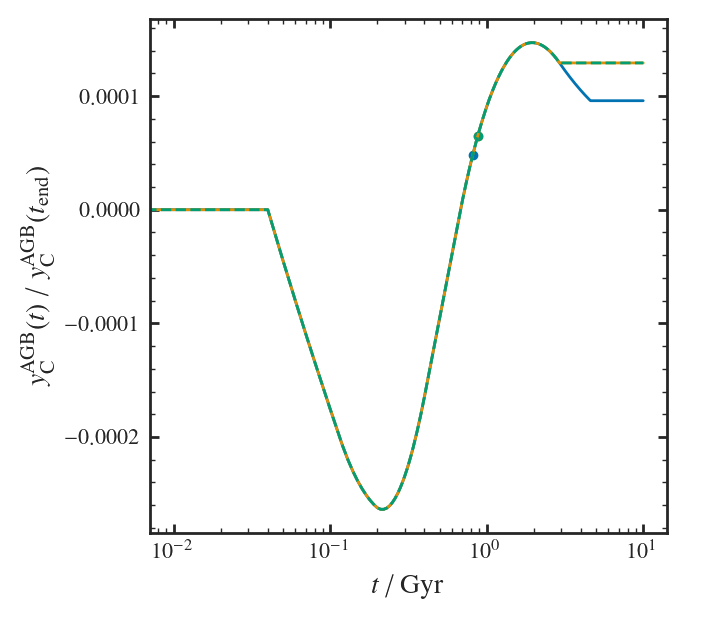

In [29]:
plt.figure(figsize=(10/3, 10/3))

Z = MH_to_Z(0.5)


for params in [params_fiducial, params_lin]:
    surp.yields.set_yields(params, verbose=False)
    vice.yields.ccsne.settings["c"] = 0
    vice.yields.sneia.settings["c"] = 0
    vice.yields.ccsne.settings["fe"] = 0
    vice.yields.agb.settings["fe"] = surp.yield_models.ZeroAGB()
    
    times, y = plot_ssp_time(normalize=False, Z=Z)

    print()

vice.yields.agb.settings["c"] = "cristallo11"
times, y = plot_ssp_time(normalize=False, Z=Z, ls="--")

arya.Legend(-1)

plt.xlabel(r"$t$ / Gyr")
plt.ylabel(r"$y_{\rm C}^{\rm AGB}(t)\;/\;y_{\rm C}^{\rm AGB}(t_{\rm end})$")
plt.xscale("log")

## Lowest mass & negative yields

In [22]:

study = "cristallo11"

y_cs = {
    "y_c_extrap": agb_interpolator("c", study=study, min_mass=0.08),
    "y_c_no_neg":  agb_interpolator("c", study=study,min_mass=0.08, no_negative=True, no_negative_mass=1.5),
    "y_c_pinch":  agb_interpolator("c", study=study,pinch_mass=0.5),
    "y_c_pinch_1":  agb_interpolator("c", study=study,pinch_mass=1.0),

    "y_c_trunc":  agb_interpolator("c", study=study,),
}

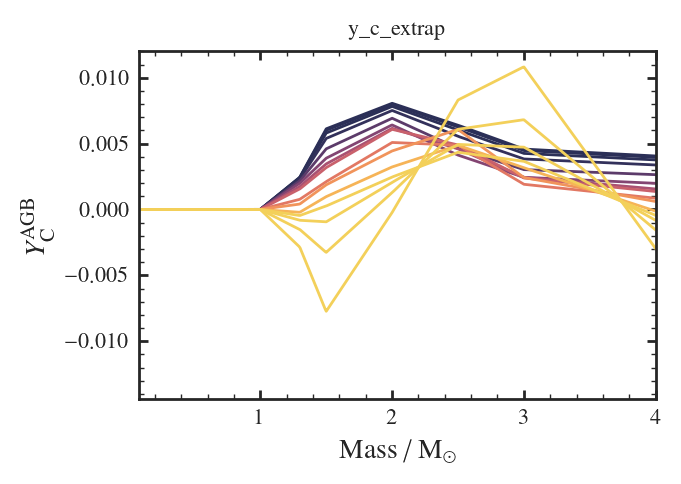

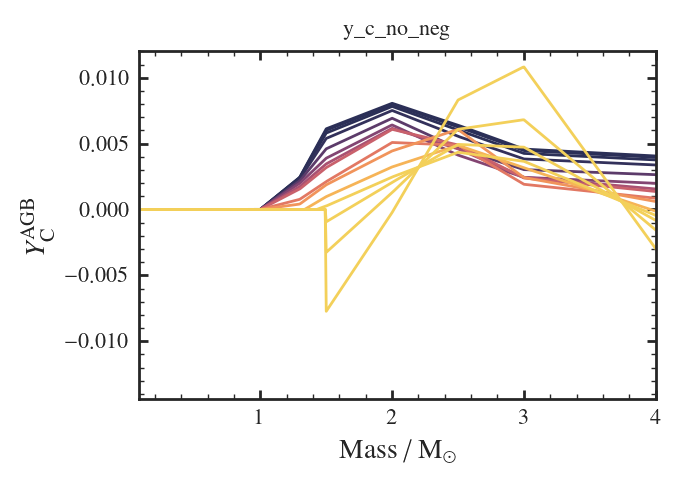

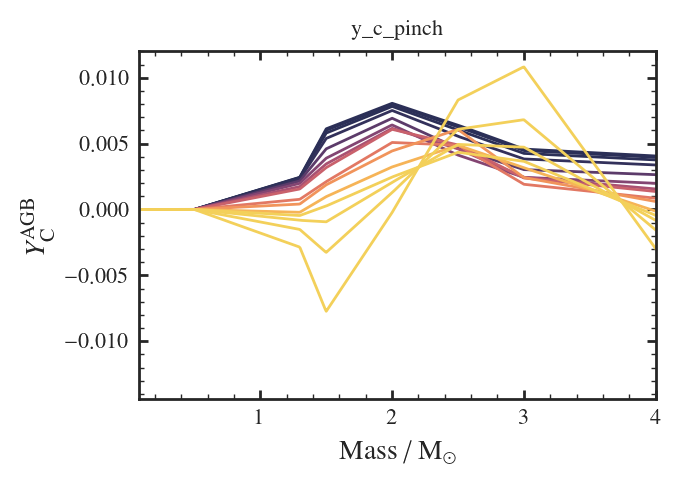

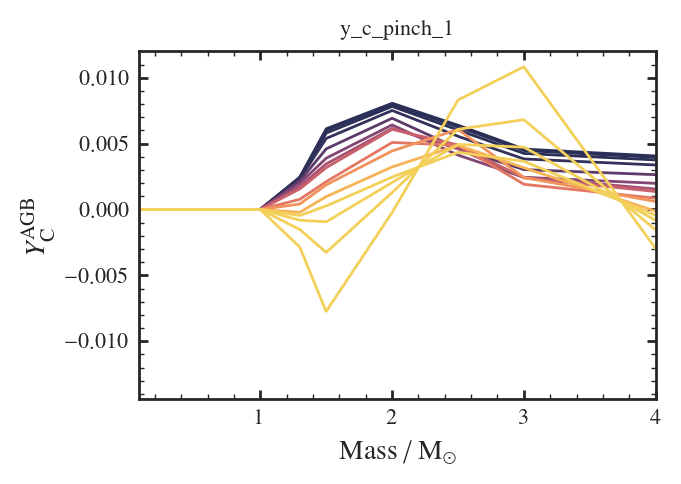

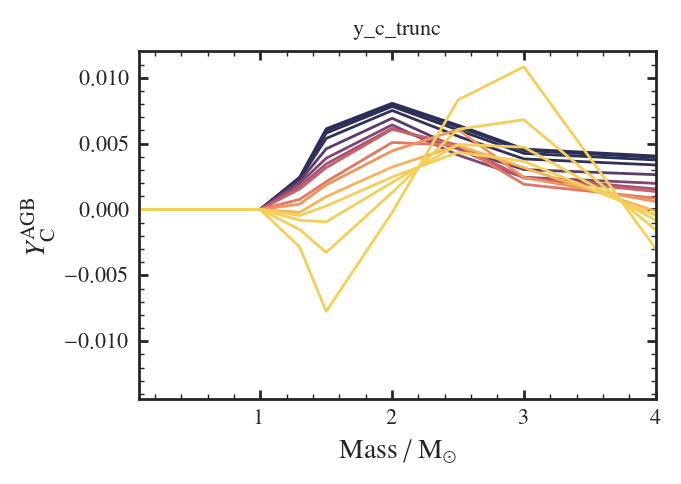

In [23]:
Zs = MH_to_Z(np.linspace(-3, 1, 15))

for label, model in y_cs.items():
    vice.yields.agb.settings["c"] = model

    plot_yields(Zs=Zs)
    plt.title(label)
    plt.xlim(0.08, 4)
    plt.show()



model = 1.00 × cristallo11
t1/2 = 1.07
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00

model = 1.00 × cristallo11
t1/2 = 1.07
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00

model = 1.00 × cristallo11
t1/2 = 1.11
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00

model = 1.00 × cristallo11
t1/2 = 1.07
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00

model = 1.00 × cristallo11
t1/2 = 1.07
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00



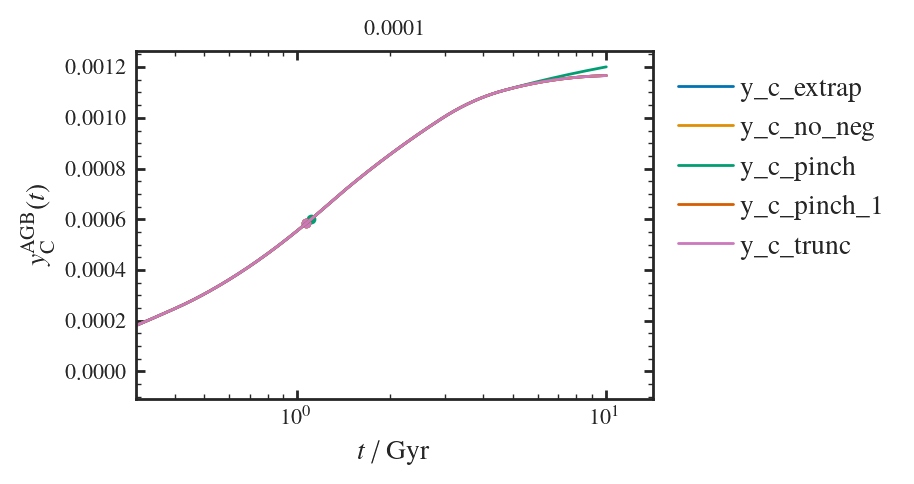

model = 1.00 × cristallo11
t1/2 = 1.04
y(t>1.01) = 0.00
y max = 0.00
y min = 0.00

model = 1.00 × cristallo11
t1/2 = 1.04
y(t>1.01) = 0.00
y max = 0.00
y min = 0.00

model = 1.00 × cristallo11
t1/2 = 1.08
y(t>1.01) = 0.00
y max = 0.00
y min = 0.00

model = 1.00 × cristallo11
t1/2 = 1.04
y(t>1.01) = 0.00
y max = 0.00
y min = 0.00

model = 1.00 × cristallo11
t1/2 = 1.04
y(t>1.01) = 0.00
y max = 0.00
y min = 0.00



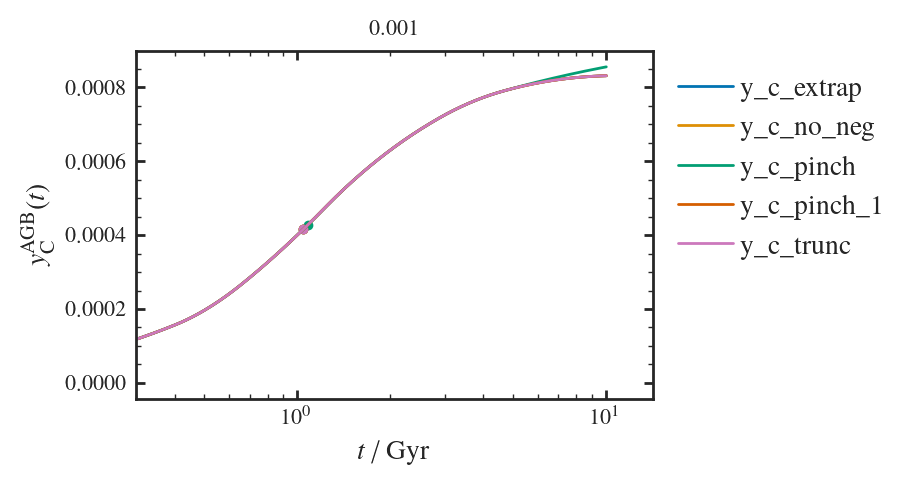

model = 1.00 × cristallo11
t1/2 = 0.79
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00

model = 1.00 × cristallo11
t1/2 = 0.81
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00

model = 1.00 × cristallo11
t1/2 = 0.78
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00

model = 1.00 × cristallo11
t1/2 = 0.79
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00

model = 1.00 × cristallo11
t1/2 = 0.79
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00



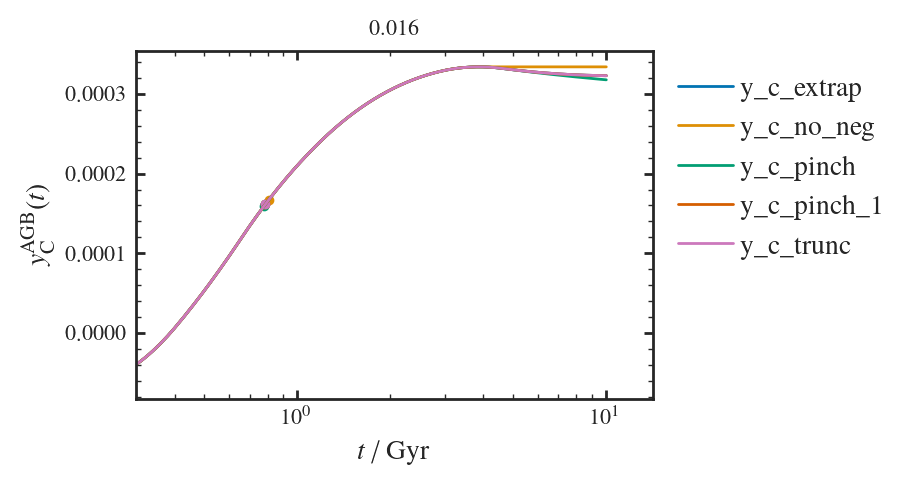

model = 1.00 × cristallo11
t1/2 = 0.78
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00

model = 1.00 × cristallo11
t1/2 = 0.83
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00

model = 1.00 × cristallo11
t1/2 = 0.77
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00

model = 1.00 × cristallo11
t1/2 = 0.78
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00

model = 1.00 × cristallo11
t1/2 = 0.78
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00



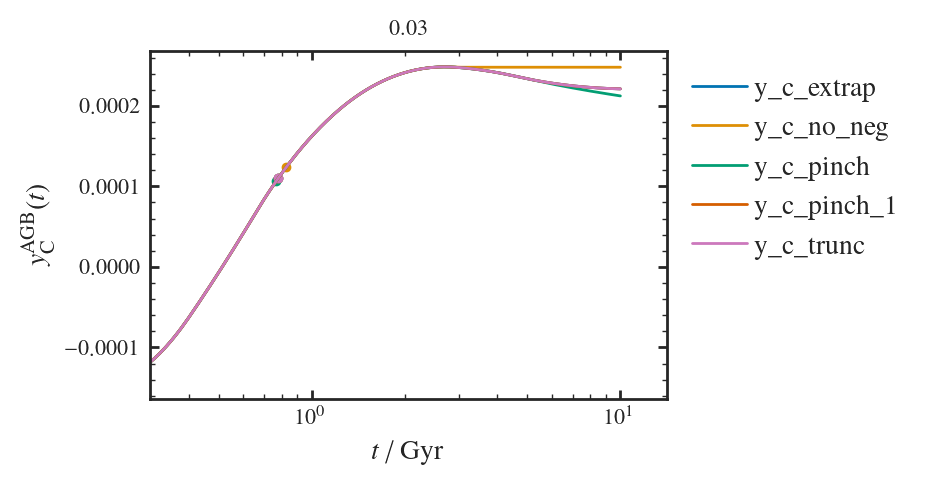

In [24]:
for Z in [1e-4, 0.001, 0.016, 0.03]:
    vice.yields.ccsne.settings["c"] = 0
    for label, model in y_cs.items():
        vice.yields.agb.settings["c"] = model

        plot_ssp_time(normalize=False, Z=Z, label=label)

    arya.Legend(-1)
    plt.title(Z)
    plt.xlim(0.3)

    plt.show()


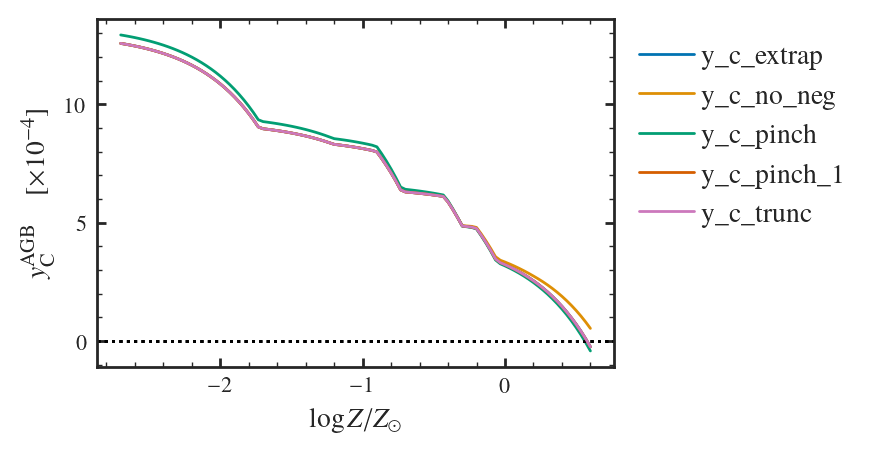

In [25]:

for label, model in y_cs.items():
    vice.yields.agb.settings["c"] = model
    plot_y_z(label=label)

arya.Legend(-1)


## M factor

## Nitrogen

In [30]:

def plot_n_table(study = "cristallo11", ax=None, fig=None, factor=1e2, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()

    y1, m1, z1 = vice.yields.agb.grid('n', study=study)
    N = len(z1)

    for i in range(N):
        y = np.array(y1)[:,i] * factor
        z = z1[i] 
        c = hmap(np.log10(z/0.014))
        f = ax.plot(m1, y, "o", label=f"Z = {z}", c=(c), **kwargs)
        f = ax.plot(m1, y, label=f"Z = {z}", c=(c), **kwargs)
        # ax.set_xticks(np.arange(1, 8))
    
    ax.axhline(0, color="k", ls=":", zorder=-1)

    return f

Text(0, 0.5, '$y_{\\rm N}$ --- R18')

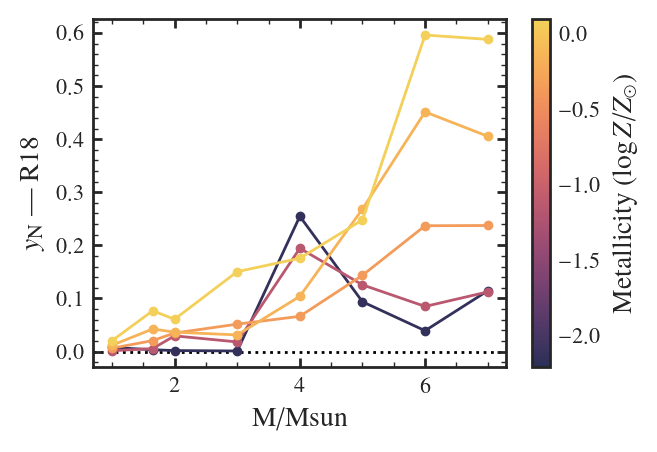

In [31]:
plot_n_table("pignatari16")
arya.Colorbar(huemap=hmap, ax=plt.gca(), label=r"Metallicity ($\log Z/Z_\odot$)")
plt.xlabel("M/Msun")
plt.ylabel(r"$y_{\rm N}$ --- R18")

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.28e-03 + 8.14e-01 (Z - Z0)   1.00 × cristallo11             0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





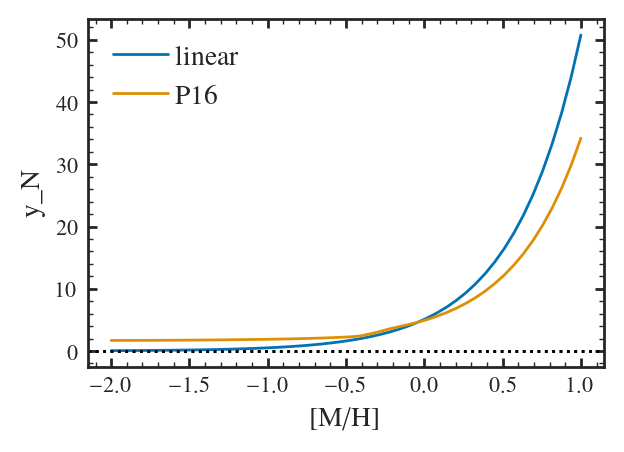

In [32]:
yields.set_yields()
Z = MH_to_Z(np.linspace(-2, 1))

plot_y_z(Z, ele="n", label="linear");

y_agb["n"] = "pignatari16"

plot_y_z(Z, ele="n", label="P16");
plt.xlabel("[M/H]")
plt.ylabel("y_N")

plt.legend()
plt.savefig("figures/_y_n_z.pdf")

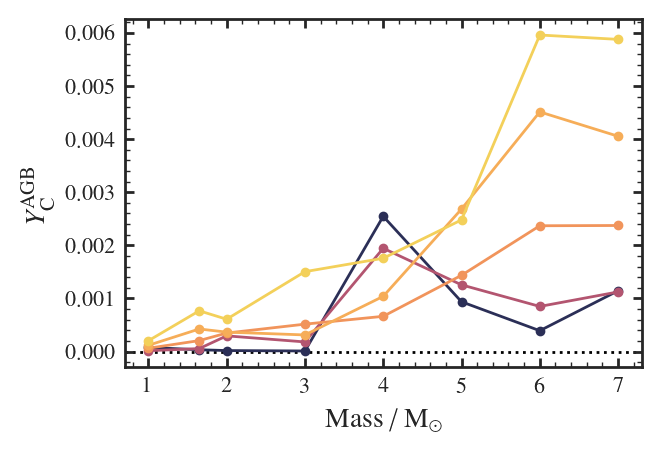

In [33]:
plot_yield_table("pignatari16", ele="n", fmt="o-")


## Testing the oob settings

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.48e-03 + 1.47e-03 [M/H] or   1.00 × cristallo11             0                              
                    8.67e-04, else                                                                               

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



model = 1.00 × cristallo11
t1/2 = 0.80
y(t>1.01) = 0.36
y max = 1.01
y min = -0.19

model = 1.00 × cristallo11
t1/2 = 0.80
y(t>1.01) = 0.

(0.03, 13.2)

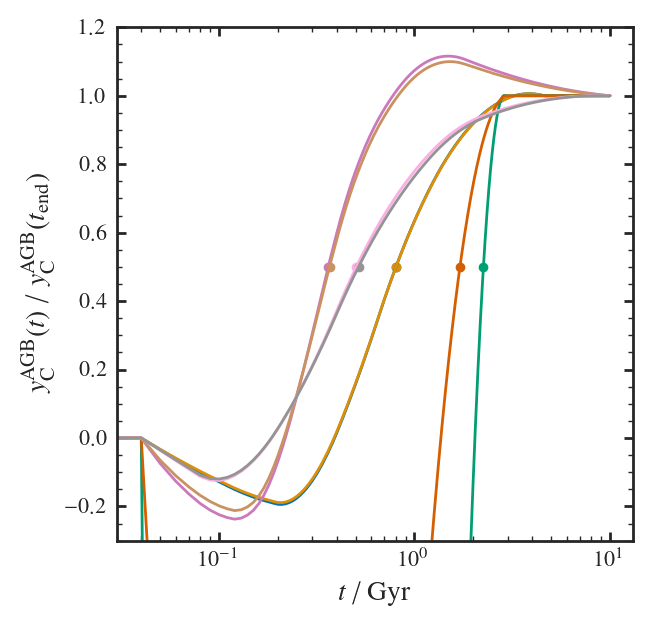

In [34]:
plt.figure(figsize=(10/3, 10/3))



for i in range(4):
    model = AGB_LABELS[i]
    yname = f"../models/{model}_oob/yield_params.json"
    surp.set_yields(surp.YieldParams.from_file(yname))
    vice.yields.ccsne.settings["c"] = 0
    times, y = plot_ssp_time()
    
    vice.yields.agb.settings["c"] = agb_interpolator("c", study=AGB_MODELS[i])
    times, y = plot_ssp_time()



plt.xlabel(r"$t$ / Gyr")
plt.ylabel(r"$y_{\rm C}^{\rm AGB}(t)\;/\;y_{\rm C}^{\rm AGB}(t_{\rm end})$")
plt.xscale("log")

plt.ylim(-0.3, 1.2)
plt.xlim(0.03, 13.2)

As expected, the surp yield settings exactly reproduce what the interpolator uses

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.48e-03 + 1.47e-03 [M/H] or   1.00 × cristallo11             0                              
                    8.67e-04, else                                                                               

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                          

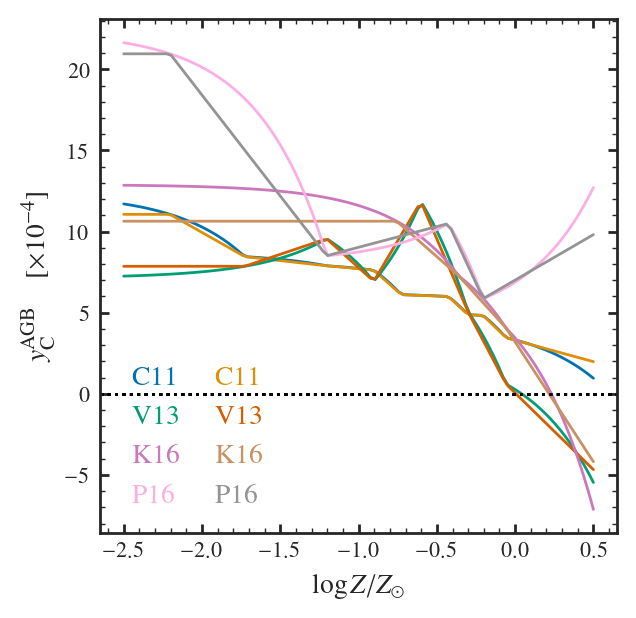

In [35]:
x_min = -2.5
x_max = 0.6
N_points = 100
scale = 1e4
ele = "c"

vice.yields.ccsne.settings[ele] = 0
vice.yields.sneia.settings[ele] = 0

plt.figure(figsize=(10/3, 10/3))

MoverH_min = -2.5
MoverH_max = 0.5
Zs = MH_to_Z(np.linspace(MoverH_min, MoverH_max, N_points))


for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings[ele] = agb_interpolator(ele, study=model)
    plot_y_z(Zs, label=AGB_LABELS[i], fmt="-")
    
    model = AGB_LABELS[i]
    yname = f"../models/{model}_oob/yield_params.json"
    surp.set_yields(surp.YieldParams.from_file(yname))
    vice.yields.ccsne.settings["c"] = 0
    
    plot_y_z(Zs, label=AGB_LABELS[i], fmt="-")

plt.axhline(0, color="k", ls=":")
plt.xlabel(r"$\log Z/Z_\odot$")
plt.ylabel(r"$y_{\rm C}^{\rm AGB}\quad[\times 10^{-4}]$")


arya.Legend(color_only=True, handlelength=0, ncols=2, columnspacing=1, loc=3, transpose=True)

## M factors

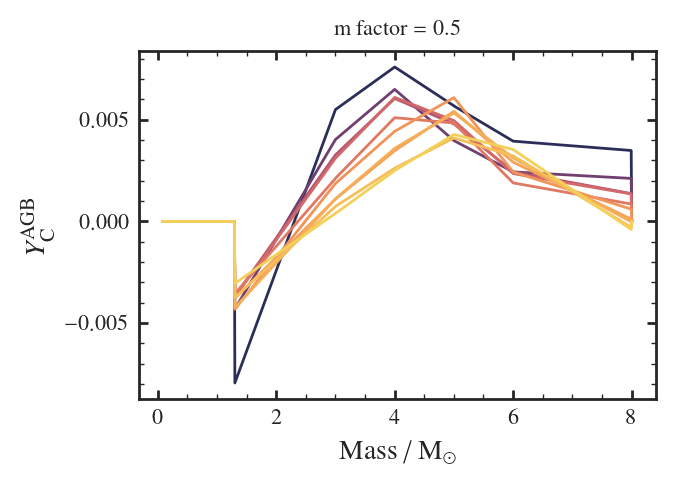

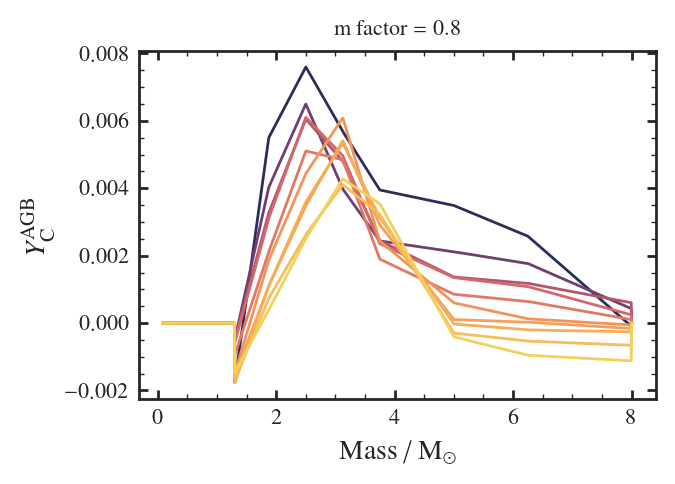

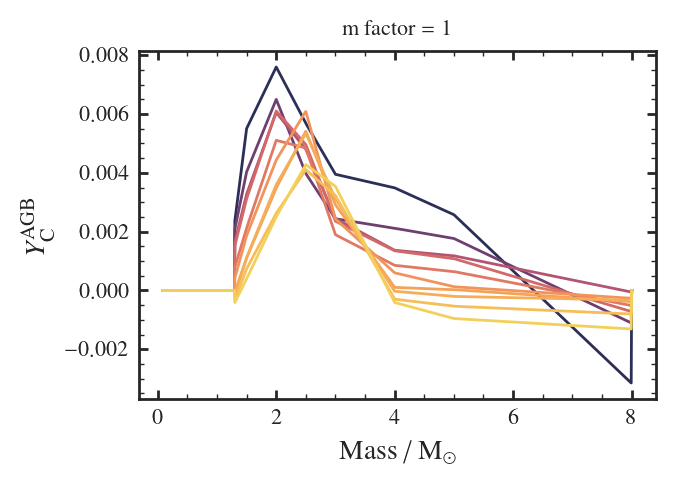

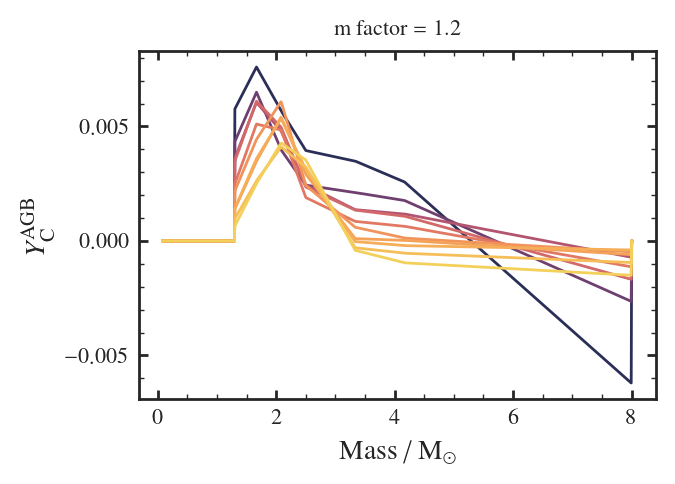

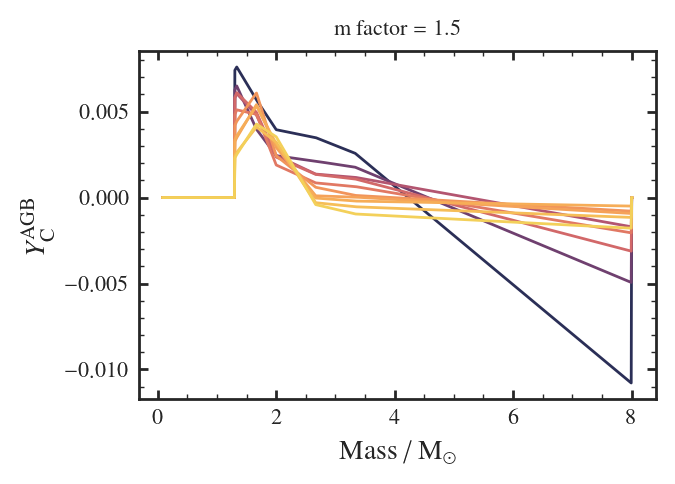

In [36]:
m_factors = [0.5, 0.8, 1, 1.2, 1.5]

for i in range(len(m_factors)):
    label = m_factors[i]
    vice.yields.agb.settings["c"] = agb_interpolator("c", mass_factor=m_factors[i])
    
    plot_yields()
    plt.title(f"m factor = {label}")
    plt.show()

model = 1.00 × cristallo11
t1/2 = 0.06
y(t>1.01) = -0.00
y max = 0.00
y min = 0.00

model = 1.00 × cristallo11
t1/2 = 0.39
y(t>1.01) = -0.00
y max = 0.00
y min = -0.00

model = 1.00 × cristallo11
t1/2 = 0.80
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00

model = 1.00 × cristallo11
t1/2 = 1.35
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00

model = 1.00 × cristallo11
t1/2 = 2.32
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00

model = 0
t1/2 = 0.26
y(t>1.01) = 0.00
y max = 0.00
y min = 0.00



([<matplotlib.axis.XTick at 0x2b24554b1d80>,
 [Text(0.1, 0, '0.1'), Text(1.0, 0, '1'), Text(10.0, 0, '10')])

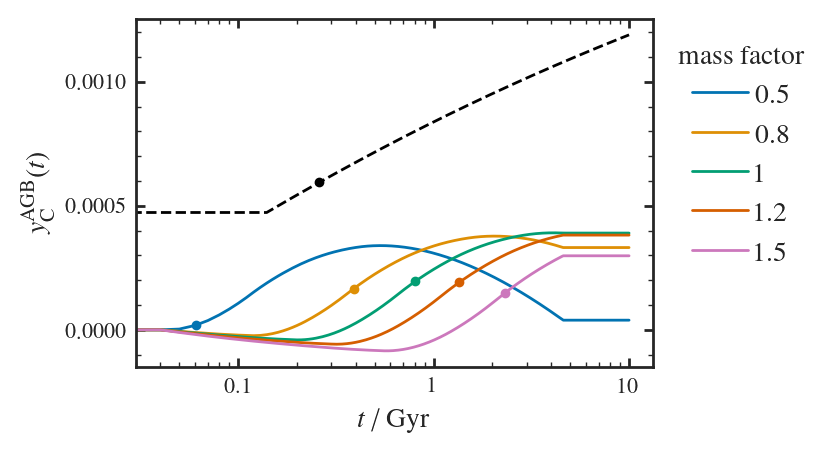

In [37]:
Z = MH_to_Z(-0.1)


m_factors = [0.5, 0.8, 1, 1.2, 1.5]

for i in range(len(m_factors)):
    label = m_factors[i]
    vice.yields.agb.settings["c"] = agb_interpolator("c", mass_factor=m_factors[i])
    plot_ssp_time(normalize=False, Z=Z, label=m_factors[i])


plot_ssp_time("fe", color="k", normalize=False, ls="--", Z=Z)

arya.Legend(-1, title="mass factor")


plt.xlim(0.03, 13.2)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])


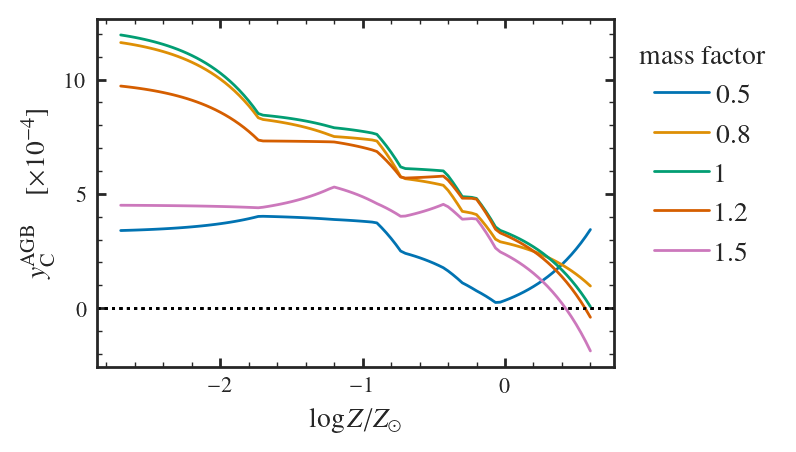

In [38]:
Z = MH_to_Z(-0.1)


m_factors = [0.5, 0.8, 1, 1.2, 1.5]

for i in range(len(m_factors)):
    label = m_factors[i]
    vice.yields.agb.settings["c"] = agb_interpolator("c", mass_factor=m_factors[i])
    plot_y_z(label=m_factors[i])



arya.Legend(-1, title="mass factor")



# IMF and MLR

powerlaw
model = 1.00 × cristallo11
t1/2 = 0.55
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00


vincenzo2016
model = 1.00 × cristallo11
t1/2 = 0.85
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00


hpt2000
model = 1.00 × cristallo11
t1/2 = 0.77
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00


ka1997
model = 1.00 × cristallo11
t1/2 = 0.89
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00


pm1993
model = 1.00 × cristallo11
t1/2 = 0.49
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00


mm1989
model = 1.00 × cristallo11
t1/2 = 1.06
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00


larson1974
model = 1.00 × cristallo11
t1/2 = 0.80
y(t>1.01) = 0.00
y max = 0.00
y min = -0.00




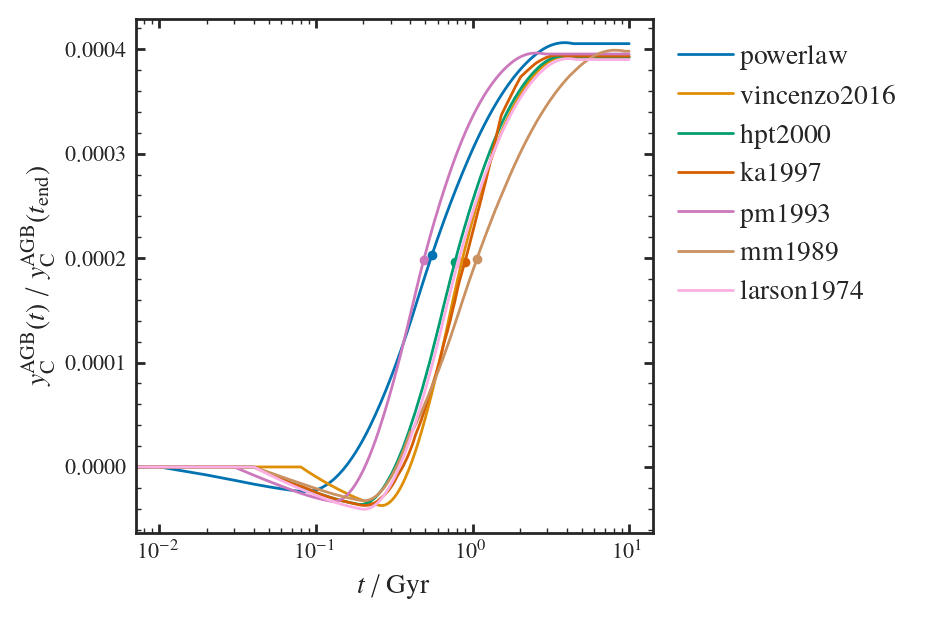

In [39]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0
vice.yields.agb.settings["fe"] = surp.yield_models.ZeroAGB()
Z = MH_to_Z(-0.1)

vice.yields.agb.settings["c"] = agb_interpolator("c", study="cristallo11")
mlrs = ["powerlaw", "vincenzo2016", "hpt2000", "ka1997", "pm1993", "mm1989", "larson1974"]

for i in range(len(mlrs)):
    label = mlrs[i]
    print(label)
    vice.mlr.setting = mlrs[i]
    
    times, y = plot_ssp_time(normalize=False, Z=Z, label=label)

    print()


arya.Legend(-1)

plt.xlabel(r"$t$ / Gyr")
plt.ylabel(r"$y_{\rm C}^{\rm AGB}(t)\;/\;y_{\rm C}^{\rm AGB}(t_{\rm end})$")
plt.xscale("log")



the MLR relation only results in small changes in the DTD.

model = 1.00 × cristallo11
t1/2 = 0.80
y(t>1.01) = 0.37
y max = 1.00
y min = -0.10

model = 1.00 × cristallo11
t1/2 = 0.81
y(t>1.01) = 0.37
y max = 1.00
y min = -0.10



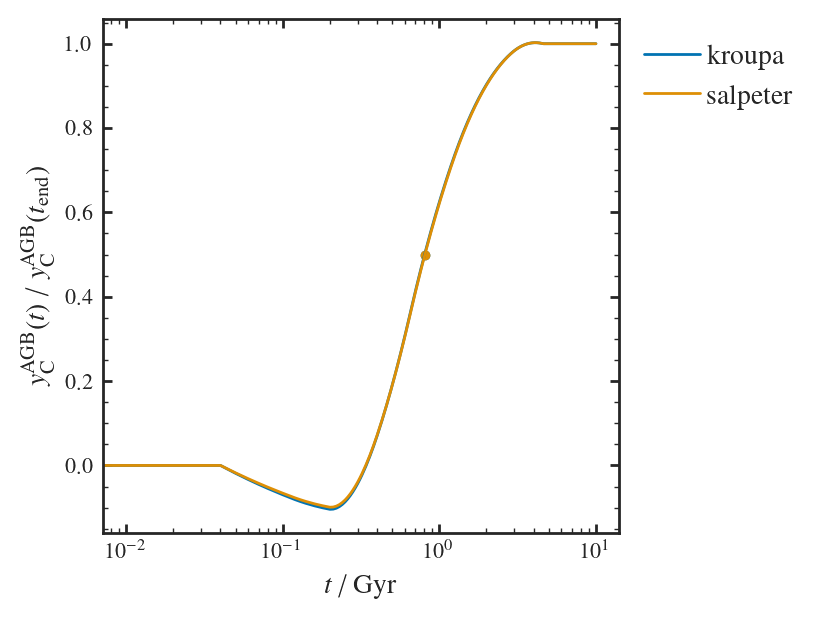

In [40]:
plt.figure(figsize=(10/3, 10/3))

Z = MH_to_Z(-0.1)
vice.yields.agb.settings["c"] = agb_interpolator("c", study="cristallo11")

times, y = plot_ssp_time(normalize=True, Z=Z, label="kroupa")
times, y = plot_ssp_time(normalize=True, Z=Z, label="salpeter", imf="salpeter")


arya.Legend(-1)

